Hihi
Používám Git na cestě: E:\Git\bin
Path exists: C:\Users\denis\Documents\GitHub\Analyzer
Pulling changes from GitHub...
Pull successful!


Enter the league file name (without extension):  E0


Available files in leagues:
Training machine learning model for league: E0.csv...
Over/Under 2.5 Model Training Completed with Ideal Parameters.
        Date       HomeTeam        AwayTeam  HomeEloBefore  AwayEloBefore  \
0 2024-08-16     Man United          Fulham         1500.0         1500.0   
1 2024-08-17        Ipswich       Liverpool         1500.0         1500.0   
2 2024-08-17        Arsenal          Wolves         1500.0         1500.0   
3 2024-08-17        Everton        Brighton         1500.0         1500.0   
4 2024-08-17      Newcastle     Southampton         1500.0         1500.0   
5 2024-08-17  Nott'm Forest     Bournemouth         1500.0         1500.0   
6 2024-08-17       West Ham     Aston Villa         1500.0         1500.0   
7 2024-08-18      Brentford  Crystal Palace         1500.0         1500.0   
8 2024-08-18        Chelsea        Man City         1500.0         1500.0   
9 2024-08-19      Leicester       Tottenham         1500.0         1500.0   

   Home

Enter the home team:  Arsenal 
Enter the away team:  Tottenham 



Team Statistics:
+-----------+---------+------+--------+--------+-------+------+-------+--------+--------+------+------+------+-----+-----+-----+-------+----------+-----+----------+--------+--------+-------+
| Team      | S       |   GP | 1.5+   | 2.5+   | BTS   | CS   | FTS   | WTN%   | LTN%   |   TG |   GF |   GA | W   | D   | L   |   P/M | P/Diff   |   F |   R/Form |   SpGS |   SpGC | Acc   |
+===========+=========+======+========+========+=======+======+=======+========+========+======+======+======+=====+=====+=====+=======+==========+=====+==========+========+========+=======+
| Arsenal   | Last 8  |    8 | 75%    | 38%    | 62%   | 38%  | 12%   | 25%    | 0%     | 3.00 | 2.25 | 0.75 | 62% | 38% | 0%  |  2.25 | 12%      |  20 |       10 |  13.10 |   6.90 | 17%   |
+-----------+---------+------+--------+--------+-------+------+-------+--------+--------+------+------+------+-----+-----+-----+-------+----------+-----+----------+--------+--------+-------+
|           | Home-L5 |    

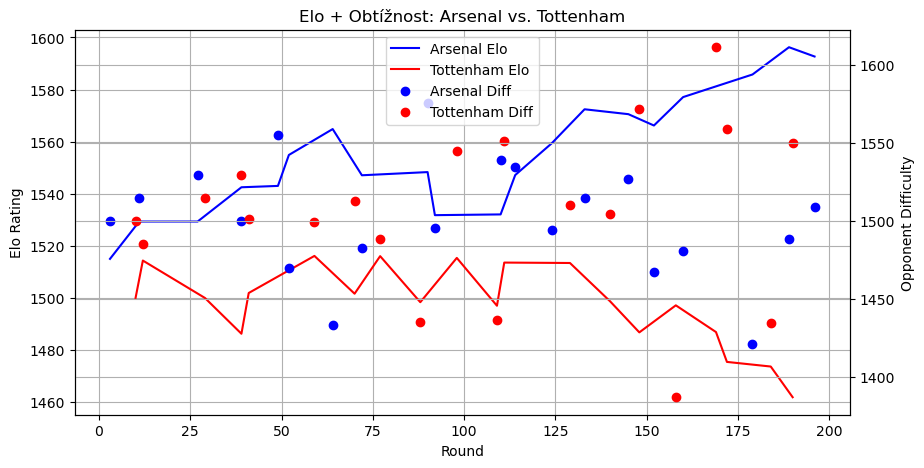

In [ ]:
import pandas as pd
import os
import xgboost
from tabulate import tabulate
from termcolor import colored
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from io import StringIO
import requests
from git import Repo
import re
import math
import numpy as np
import os
import matplotlib.pyplot as plt
import platform
import json
from sklearn.metrics import mean_squared_error


#repo_path = r"C:\Users\denis\Documents\GitHub\Analyzer"  # Cesta k vašemu repozitáři

# Načtení JSON konfigurace
config_file = "config.json"
with open(config_file, "r") as f:
    config = json.load(f)

# Zjištění názvu aktuálního počítače
pc_name = platform.node()
print(pc_name)
# Výběr správné cesty z konfigurace
if pc_name in config:
    git_path = config[pc_name]["git_path"]
    repo_path = config[pc_name]["repo_path"]  # Tady chybí repo_path
else:
    raise ValueError(f"PC '{pc_name}' nebyl nalezen v konfiguraci")

print(f"Používám Git na cestě: {git_path}")

# Pull changes from GitHub
def pull_changes(repo_path):
    try:
        repo = Repo(repo_path)
        origin = repo.remotes.origin
        print("Pulling changes from GitHub...")
        origin.pull('main')  # Použijte větev main
        print("Pull successful!")
    except Exception as e:
        print(f"Error during pull: {e}")


# Push changes to GitHub
def push_changes(repo_path, commit_message):
    try:
        repo = Repo(repo_path)
        repo.git.add(A=True)  # Add all changes
        repo.index.commit(commit_message)  # Create a commit
        origin = repo.remotes.origin
        print("Pushing changes to GitHub...")
        origin.push()
        print("Push successful.")
    except Exception as e:
        print(f"Error during push: {e}")

def list_files_in_github_directory(repo_api_url):
    response = requests.get(repo_api_url)
    if response.status_code == 200:
        files = response.json()
        return [file['name'] for file in files if file['name'].endswith('.csv')]
    else:
        raise Exception(f"Error fetching directory listing. Status code: {response.status_code}")

def load_data_from_github(file_url):
    response = requests.get(file_url)
    if response.status_code == 200:
        return pd.read_csv(StringIO(response.text))
    else:
        raise Exception(f"Error fetching data from {file_url}. Status code: {response.status_code}")


def load_data(file_path):
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None



def filter_team_data(df, team):
    """Filter matches involving the given team."""
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a DataFrame as input to filter_team_data.")
    return df[
        (df['HomeTeam'].str.lower() == team.lower()) |
        (df['AwayTeam'].str.lower() == team.lower())
    ]

def filter_head_to_head_matches(df, team1, team2):
    """
    Filter head-to-head matches between the given teams.

    Parameters:
        df (pd.DataFrame): DataFrame containing match data.
        team1 (str): Name of the first team.
        team2 (str): Name of the second team.

    Returns:
        pd.DataFrame: DataFrame containing only head-to-head matches between team1 and team2.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a DataFrame as input to filter_head_to_head_matches.")
    
    if not isinstance(team1, str) or not isinstance(team2, str):
        raise TypeError("Team names must be strings.")

    return df[
        ((df['HomeTeam'].str.lower() == team1.lower()) & (df['AwayTeam'].str.lower() == team2.lower())) |
        ((df['HomeTeam'].str.lower() == team2.lower()) & (df['AwayTeam'].str.lower() == team1.lower()))
    ]



def filter_home_team_data(df, team):
    """Filter matches where the team played as the home team."""
    home_matches = df[df['HomeTeam'].str.lower() == team.lower()]
    return home_matches

def filter_away_team_data(df, team):
    """Filter matches where the team played as the away team."""
    away_matches = df[df['AwayTeam'].str.lower() == team.lower()]
    return away_matches

def load_elo_files(history_path, actual_path):
    # Load historical matches
    history_files = [os.path.join(history_path, f) for f in os.listdir(history_path) if f.endswith('.csv')]
    actual_files = [os.path.join(actual_path, f) for f in os.listdir(actual_path) if f.endswith('.csv')]
    
    # Combine all historical data
    historical_data = pd.concat([pd.read_csv(file) for file in history_files], ignore_index=True)
    actual_data = pd.concat([pd.read_csv(file) for file in actual_files], ignore_index=True)
    
    return historical_data, actual_data

def calculate_elo_for_season(historical_data, actual_data):
    teams = pd.concat([historical_data['HomeTeam'], historical_data['AwayTeam']]).unique()
    elo_ratings = {team: 1500 for team in teams}  # Default Elo rating

    # Update Elo ratings using historical matches
    for _, row in historical_data.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        home_goals, away_goals = row['FTHG'], row['FTAG']
        elo_ratings = update_elo(elo_ratings, home_team, away_team, home_goals, away_goals)

    # Update Elo ratings using actual matches
    for _, row in actual_data.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        home_goals, away_goals = row['FTHG'], row['FTAG']
        elo_ratings = update_elo(elo_ratings, home_team, away_team, home_goals, away_goals)

    return elo_ratings

def calculate_elo_for_season_only_actual(actual_data):
    teams = pd.concat([actual_data['HomeTeam'], actual_data['AwayTeam']]).unique()
    elo_ratings = {team: 1500 for team in teams}  # Default Elo rating

    # Update Elo ratings using actual matches
    for _, row in actual_data.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        home_goals, away_goals = row['FTHG'], row['FTAG']
        elo_ratings = update_elo(elo_ratings, home_team, away_team, home_goals, away_goals)

    return elo_ratings

def calculate_recent_elo(data, num_matches=8):
    """Calculate Elo ratings based on the last num_matches for each team."""
    recent_data = data.tail(num_matches)
    teams = pd.concat([recent_data['HomeTeam'], recent_data['AwayTeam']]).unique()
    recent_elo = {team: 1500 for team in teams}

    for _, row in recent_data.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        home_goals, away_goals = row['FTHG'], row['FTAG']
        recent_elo = update_elo(recent_elo, home_team, away_team, home_goals, away_goals)

    return recent_elo

def calculate_elo_for_home_games(actual_data, home_advantage=50):

    teams = pd.concat([actual_data['HomeTeam'], actual_data['AwayTeam']]).unique()
    elo_ratings = {team: 1500 for team in teams}  # Default Elo rating

    def update_elo(elo_ratings, home_team, away_team, home_goals, away_goals, home_advantage):
        # Calculate expected outcomes
        home_rating = elo_ratings[home_team] + home_advantage
        away_rating = elo_ratings[away_team]

        expected_home = 1 / (1 + 10 ** ((away_rating - home_rating) / 400))
        expected_away = 1 / (1 + 10 ** ((home_rating - away_rating) / 400))

        # Determine actual outcome
        if home_goals > away_goals:
            actual_home, actual_away = 1, 0
        elif home_goals < away_goals:
            actual_home, actual_away = 0, 1
        else:
            actual_home, actual_away = 0.5, 0.5

        # Update ratings
        k_factor = 30  # Standard K-factor
        elo_ratings[home_team] += k_factor * (actual_home - expected_home)
        elo_ratings[away_team] += k_factor * (actual_away - expected_away)

        return elo_ratings

    # Update Elo ratings using home matches only
    for _, row in actual_data.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        home_goals, away_goals = row['FTHG'], row['FTAG']
        elo_ratings = update_elo(elo_ratings, home_team, away_team, home_goals, away_goals, home_advantage)

    return elo_ratings

def calculate_team_elo_progress(data, team, num_matches=None):
    """Calculate the Elo points gained by a team over a specific number of matches."""
    team_matches = data[(data['HomeTeam'] == team) | (data['AwayTeam'] == team)]
    
    # Filter last `num_matches` if specified
    if num_matches:
        team_matches = team_matches.tail(num_matches)
    
    # Initialize Elo
    team_elo = 1500
    
    # Calculate Elo changes
    for _, row in team_matches.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        home_goals, away_goals = row['FTHG'], row['FTAG']
        elo_ratings = {home_team: team_elo, away_team: team_elo}  # Initialize ratings
        elo_ratings = update_elo(elo_ratings, home_team, away_team, home_goals, away_goals)
        if team == home_team:
            team_elo = elo_ratings[home_team]
        elif team == away_team:
            team_elo = elo_ratings[away_team]
    
    # Calculate Elo points gained
    points_gained = team_elo - 1500
    return points_gained


# Compare form
def compare_elo_form(team, elo_ratings_actual, recent_elo_ratings):
    season_elo = elo_ratings_actual.get(team, 1500)
    recent_elo = recent_elo_ratings.get(team, 1500)
    return season_elo, recent_elo, recent_elo - season_elo


def update_elo(elo_ratings, home_team, away_team, home_goals, away_goals, K=30):
    """Update Elo ratings based on match results."""
    # Ensure both teams exist in the Elo ratings
    if home_team not in elo_ratings:
        elo_ratings[home_team] = 1500
    if away_team not in elo_ratings:
        elo_ratings[away_team] = 1500

    result = 1 if home_goals > away_goals else 0.5 if home_goals == away_goals else 0

    # Home team
    expected_home = calculate_expected_score(elo_ratings[home_team], elo_ratings[away_team])
    elo_ratings[home_team] += K * (result - expected_home)

    # Away team
    expected_away = calculate_expected_score(elo_ratings[away_team], elo_ratings[home_team])
    elo_ratings[away_team] += K * ((1 - result) - expected_away)

    return elo_ratings

def calculate_expected_score(elo_team, elo_opponent):
    """Calculate the expected score for a team based on Elo."""
    return 1 / (1 + 10 ** ((elo_opponent - elo_team) / 400))


def calculate_points(team_matches, team):
    """Calculate average points from matches."""
    total_points = 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'].lower() == team.lower():
            if match['FTHG'] > match['FTAG']:
                total_points += 3
            elif match['FTHG'] == match['FTAG']:
                total_points += 1
        elif match['AwayTeam'].lower() == team.lower():
            if match['FTAG'] > match['FTHG']:
                total_points += 3
            elif match['FTAG'] == match['FTHG']:
                total_points += 1
    avg_points = total_points / len(team_matches) if len(team_matches) > 0 else 0
    return avg_points

def calculate_percentage_difference(current, season):
    """Calculate the percentage difference between current and season averages."""
    return ((current - season) / season * 100) if season > 0 else 0

def calculate_average_goals(team_matches, team):
    """Calculate average goals scored and conceded for a team."""
    total_scored, total_conceded = 0, 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'].lower() == team.lower():
            total_scored += match['FTHG']
            total_conceded += match['FTAG']
        elif match['AwayTeam'].lower() == team.lower():
            total_scored += match['FTAG']
            total_conceded += match['FTHG']
    avg_scored = total_scored / len(team_matches) if len(team_matches) > 0 else 0
    avg_conceded = total_conceded / len(team_matches) if len(team_matches) > 0 else 0
    return avg_scored, avg_conceded

def calculate_average_shots(team_matches, team):
    """Calculate average goals scored and conceded for a team."""
    total_scored, total_conceded = 0, 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'].lower() == team.lower():
            total_scored += match['HS']
            total_conceded += match['AS']
        elif match['AwayTeam'].lower() == team.lower():
            total_scored += match['AS']
            total_conceded += match['HS']
    avg_scored = total_scored / len(team_matches) if len(team_matches) > 0 else 0
    avg_conceded = total_conceded / len(team_matches) if len(team_matches) > 0 else 0
    return avg_scored, avg_conceded

def calculate_over_1_5_percentage(team_matches):
    """Calculate the percentage of matches with over 1.5 goals."""
    over_1_5 = 0
    for _, match in team_matches.iterrows():
        if (match['FTHG'] + match['FTAG']) > 1.5:
            over_1_5 += 1
    return (over_1_5 / len(team_matches)) * 100 if len(team_matches) > 0 else 0

def calculate_over_2_5_percentage(team_matches):
    """Calculate the percentage of matches with over 2.5 goals."""
    over_2_5 = 0
    for _, match in team_matches.iterrows():
        if (match['FTHG'] + match['FTAG']) > 2.5:
            over_2_5 += 1
    return (over_2_5 / len(team_matches)) * 100 if len(team_matches) > 0 else 0

def calculate_both_teams_scored_percentage(team_matches):
    """Calculate the percentage of matches where both teams scored."""
    bts = 0
    for _, match in team_matches.iterrows():
        if match['FTHG'] > 0 and match['FTAG'] > 0:
            bts += 1
    return (bts / len(team_matches)) * 100 if len(team_matches) > 0 else 0

def calculate_clean_sheet_percentage(team_matches, team):
    """Calculate the percentage of matches where the team kept a clean sheet."""
    clean_sheets = 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'].lower() == team.lower() and match['FTAG'] == 0:
            clean_sheets += 1
        elif match['AwayTeam'].lower() == team.lower() and match['FTHG'] == 0:
            clean_sheets += 1
    return (clean_sheets / len(team_matches)) * 100 if len(team_matches) > 0 else 0

def calculate_failed_to_score_percentage(team_matches, team):
    """Calculate the percentage of matches where the team failed to score."""
    fts = 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'].lower() == team.lower() and match['FTHG'] == 0:
            fts += 1
        elif match['AwayTeam'].lower() == team.lower() and match['FTAG'] == 0:
            fts += 1
    return (fts / len(team_matches)) * 100 if len(team_matches) > 0 else 0

def calculate_total_average_goals(team_matches):
    """Calculate the average total goals in matches."""
    total_goals = 0
    for _, match in team_matches.iterrows():
        total_goals += match['FTHG'] + match['FTAG']
    return total_goals / len(team_matches) if len(team_matches) > 0 else 0

def highlight_value(value, column):
    """Highlight specific values based on conditions."""
    thresholds = {
        "2.5+%": 65,
        "1.5+%": 85,
        "BTS%": 60,
        "CS%": 18,
        "FTS%": 18,
        "TG": 2.9,
        "GF": 1.9,
        "GA": 1.1,
        "GF_Diff": 10,
        "GA_Diff": 10,
        "P_Diff": 10
    }
    try:
        numeric_value = float(value.strip('%'))
        if column in ["GF_Diff", "GA_Diff", "P_Diff"]:
            if numeric_value > thresholds[column]:
                return colored(value, 'green')
            elif numeric_value < -thresholds[column]:
                return colored(value, 'red')
        elif column in thresholds:
            if (column in ["CS%", "FTS%"] and numeric_value < thresholds[column]) or \
               (column not in ["CS%", "FTS%"] and numeric_value > thresholds[column]):
                return colored(value, 'green')
    except ValueError:
        pass
    return value

def remove_ansi(value):
    """Remove ANSI escape sequences (color formatting)."""
    if isinstance(value, str):
        return re.sub(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])', '', value)
    return value  # Return unchanged if not a string

def calculate_bet_score(stats):
    """Calculate bet eligibility score based on criteria."""
    score = 0
    stats = [remove_ansi(val) for val in stats]  # Remove ANSI formatting
    if float(stats[3].strip('%')) > 80: score += 1  # 1.5+%
    if float(stats[4].strip('%')) > 60: score += 1.2  # 2.5+%
    if float(stats[5].strip('%')) > 60: score += 1.2  # BTS%
    if float(stats[6].strip('%')) < 25: score += 1  # CS%
    if float(stats[7].strip('%')) < 25: score += 1  # FTS%
    if float(stats[8].strip('%')) < 25: score += 1  # WTN%
    if float(stats[9].strip('%')) < 25: score += 1  # FTS%
    if float(stats[10]) > 2.8: score += 1            # TG
    if float(stats[11]) > 1.8: score += 1            # GF
    if float(stats[12]) > 1.2: score += 1           # GA

    return (score / 8.4) * 100

def calculate_win_draw_loss_percentage(team_matches, team):
    """Calculate the percentage of wins, draws, and losses for a team."""
    wins, draws, losses = 0, 0, 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'].lower() == team.lower():
            if match['FTHG'] > match['FTAG']:
                wins += 1
            elif match['FTHG'] == match['FTAG']:
                draws += 1
            else:
                losses += 1
        elif match['AwayTeam'].lower() == team.lower():
            if match['FTAG'] > match['FTHG']:
                wins += 1
            elif match['FTAG'] == match['FTHG']:
                draws += 1
            else:
                losses += 1
    total_matches = len(team_matches)
    win_percentage = (wins / total_matches) * 100 if total_matches > 0 else 0
    draw_percentage = (draws / total_matches) * 100 if total_matches > 0 else 0
    loss_percentage = (losses / total_matches) * 100 if total_matches > 0 else 0
    return win_percentage, draw_percentage, loss_percentage

def calculate_points_per_match(team_matches, team):
    """Calculate the average points per match for a team."""
    total_points = 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'].lower() == team.lower():
            if match['FTHG'] > match['FTAG']:
                total_points += 3
            elif match['FTHG'] == match['FTAG']:
                total_points += 1
        elif match['AwayTeam'].lower() == team.lower():
            if match['FTAG'] > match['FTHG']:
                total_points += 3
            elif match['FTAG'] == match['FTHG']:
                total_points += 1
    avg_points_per_match = total_points / len(team_matches) if len(team_matches) > 0 else 0
    return avg_points_per_match

def calculate_won_to_nil_percentage(matches, team):
    """
    Calculate the percentage of matches won to nil (WTN).
    """
    if len(matches) == 0:
        return 0
    # Pro domácí tým
    home_won_to_nil = matches[
        (matches['HomeTeam'] == team) & (matches['FTHG'] > matches['FTAG']) & (matches['FTAG'] == 0)
    ].shape[0]
    # Pro hostující tým
    away_won_to_nil = matches[
        (matches['AwayTeam'] == team) & (matches['FTAG'] > matches['FTHG']) & (matches['FTHG'] == 0)
    ].shape[0]
    # Celkem
    total_won_to_nil = home_won_to_nil + away_won_to_nil
    return (total_won_to_nil / len(matches)) * 100


def calculate_lost_to_nil_percentage(matches, team):
    """
    Calculate the percentage of matches lost to nil (LTN).
    """
    if len(matches) == 0:
        return 0
    # Pro domácí tým
    home_lost_to_nil = matches[
        (matches['HomeTeam'] == team) & (matches['FTAG'] > matches['FTHG']) & (matches['FTHG'] == 0)
    ].shape[0]
    # Pro hostující tým
    away_lost_to_nil = matches[
        (matches['AwayTeam'] == team) & (matches['FTHG'] > matches['FTAG']) & (matches['FTAG'] == 0)
    ].shape[0]
    # Celkem
    total_lost_to_nil = home_lost_to_nil + away_lost_to_nil
    return (total_lost_to_nil / len(matches)) * 100


def calculate_points_percentage_difference(team_matches, team, season_matches):
    """Calculate percentage difference between all season matches and the last 8 matches."""
    avg_points_last_8 = calculate_points_per_match(team_matches, team)
    season_team_matches = filter_team_data(season_matches, team)
    avg_points_season = calculate_points_per_match(season_team_matches, team)

    percentage_difference = ((avg_points_last_8 - avg_points_season) / avg_points_season * 100) if avg_points_season > 0 else 0
    return percentage_difference

def calculate_team_form(season_matches, team):
    """Calculate the form of a team over the season with a custom point system."""
    form_points = 0
    for _, match in season_matches.iterrows():
        # Skip rows with NaN values
        if pd.isnull(match['HomeTeam']) or pd.isnull(match['AwayTeam']):
            continue

        if match['HomeTeam'].lower() == team.lower():
            if match['FTHG'] > match['FTAG']:
                form_points += 2  # Win
            elif match['FTHG'] == match['FTAG']:
                form_points += 0  # Draw
            else:
                form_points -= 1  # Loss
        elif match['AwayTeam'].lower() == team.lower():
            if match['FTAG'] > match['FTHG']:
                form_points += 2  # Win
            elif match['FTAG'] == match['FTHG']:
                form_points += 0  # Draw
            else:
                form_points -= 1  # Loss
    return form_points

"Max recent points 0 - "
def calculate_recent_form(recent_matches, team):
    """Calculate the form of a team over the last 8 matches with a custom point system."""
    form_points = 0
    for _, match in recent_matches.iterrows():
        if match['HomeTeam'].lower() == team.lower():
            if match['FTHG'] > match['FTAG']:
                form_points += 2  # Win
            elif match['FTHG'] == match['FTAG']:
                form_points += 0  # Draw
            else:
                form_points -= 1  # Loss
        elif match['AwayTeam'].lower() == team.lower():
            if match['FTAG'] > match['FTHG']:
                form_points += 2  # Win
            elif match['FTAG'] == match['FTHG']:
                form_points += 0  # Draw
            else:
                form_points -= 1  # Loss
    return form_points

def calculate_shooting_accuracy(avg_scored, avg_scored_shots):
    """
    Calculate the shooting accuracy based on average goals scored and average shots taken.
    :param avg_scored: Average goals scored.
    :param avg_scored_shots: Average shots taken.
    :return: Shooting accuracy as a percentage.
    """
    return (avg_scored / avg_scored_shots * 100) if avg_scored_shots > 0 else 0


def calculate_over_2_5_prob(home_probs, away_probs):
    """Calculate the probability of over 2.5 goals based on Poisson probabilities."""
    over_2_5_prob = 0
    for i, home_prob in enumerate(home_probs):
        for j, away_prob in enumerate(away_probs):
            if i + j > 2:  # Only consider cases where total goals > 2.5
                over_2_5_prob += home_prob * away_prob
    return over_2_5_prob

def calculate_poisson_distribution(home_attack, away_attack, home_defense, away_defense, avg_home_goals, avg_away_goals):
    """Calculate Poisson distribution probabilities for match outcomes."""
    home_expected_goals = home_attack * away_defense * avg_home_goals
    away_expected_goals = away_attack * home_defense * avg_away_goals

    home_probs = [poisson_probability(home_expected_goals, i) for i in range(6)]
    away_probs = [poisson_probability(away_expected_goals, i) for i in range(6)]

    return home_probs, away_probs

def poisson_probability(expected_goals, actual_goals):
    """Calculate Poisson probability for a specific number of goals."""
    return (math.exp(-expected_goals) * (expected_goals ** actual_goals)) / math.factorial(actual_goals)

def display_poisson_table(home_team, away_team, home_probs, away_probs):
    """Display Poisson probabilities for each scoreline."""
    print(f"\nPoisson Distribution - Predicted Score Probabilities ({home_team} vs {away_team}):")
    headers = ["Goals"] + [f"{i}" for i in range(6)]
    table = []
    for i, home_prob in enumerate(home_probs):
        row = [f"{i}"] + [f"{home_prob * away_prob:.2%}" for away_prob in away_probs]
        table.append(row)
    print(tabulate(table, headers=headers, tablefmt="grid"))

def calculate_total_goals(team_matches, team):
    """
    Calculate the total number of goals scored by a specific team in matches.
    :param team_matches: DataFrame containing match data.
    :param team: Team name for which to calculate goals.
    :return: Total number of goals scored by the team.
    """
    total_goals = 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'] == team:
            total_goals += match['FTHG']
        elif match['AwayTeam'] == team:
            total_goals += match['FTAG']
    return total_goals

def calculate_total_shots(team_matches, team):
    """
    Calculate the total number of shots made by a specific team in matches.
    :param team_matches: DataFrame containing match data.
    :param team: Team name for which to calculate shots.
    :return: Total number of shots made by the team.
    """
    total_shots = 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'] == team:
            total_shots += match['HS']  # HS: Home Shots
        elif match['AwayTeam'] == team:
            total_shots += match['AS']  # AS: Away Shots
    return total_shots

# Dynamická funkce pro penalizaci
def calculate_penalty(delta_elo, max_diff, avg_diff):
    if delta_elo <= avg_diff:
        return 1.0  # Žádná penalizace
    elif delta_elo <= max_diff / 2:
        return 1.0 - (delta_elo - avg_diff) / (max_diff / 2 - avg_diff) * 0.1  # Penalizace až 10 %
    else:
        return 0.9  # Maximální penalizace

def calculate_penalty_fix(delta_elo):
    # Definice penalizací pro různé hodnoty delta_elo
    penalty_table = [
        (0, 1.00),
        (25, 0.98),
        (50, 0.96),
        (75, 0.94),
        (100, 0.90),
        (125, 0.88),
        (150, 0.86),
        (175, 0.84),
        (200, 0.80),
    ]
    # Najdeme interval, kam delta_elo spadá
    for i in range(len(penalty_table) - 1):
        low, low_penalty = penalty_table[i]
        high, high_penalty = penalty_table[i + 1]
        
        if low <= delta_elo <= high:
            # Lineární interpolace mezi nízkou a vysokou hodnotou
            return low_penalty + (high_penalty - low_penalty) * (delta_elo - low) / (high - low)
    
    # Pokud je delta_elo mimo tabulku, použijeme minimální penalizaci
    return penalty_table[-1][1]  # 0.70 pro delta_elo > 200

def display_team_stats(df, team, scope, team_name, display_name):
    """Display statistics for a team in a single row format with specific match scopes."""
    if scope == "L8":
        matches = filter_team_data(df, team).tail(8)
        label = "Last 8"
    elif scope == "H5":
        matches = filter_home_team_data(df, team).tail(5)
        label = "Home-L5"
    elif scope == "A5":
        matches = filter_away_team_data(df, team).tail(5)
        label = "Away-L5"
    else:
        return

    avg_points = calculate_points(matches, team)
    avg_scored, avg_conceded = calculate_average_goals(matches, team)
    avg_scored_shots, avg_conceded_shots = calculate_average_shots(matches, team)
    win_percentage, draw_percentage, loss_percentage = calculate_win_draw_loss_percentage(matches, team)
    avg_points_per_match = calculate_points_per_match(matches, team)
    percentage_diff_points = calculate_points_percentage_difference(matches, team, df)
    form_points = calculate_team_form(df, team)
    recent_form_points= calculate_recent_form(matches,team)
    total_shots=calculate_total_shots(matches,team)
    total_goals=calculate_total_goals(matches,team)
    accuracy= calculate_shooting_accuracy(avg_scored, avg_scored_shots)
    won_to_nil = calculate_won_to_nil_percentage(matches, team)
    lost_to_nil = calculate_lost_to_nil_percentage(matches, team)

    stats = [
        display_name,  # Team Name
        label,  # Scope
        len(matches),  # Games Played
        highlight_value(f"{calculate_over_1_5_percentage(matches):.0f}%", "1.5+%"),  # Over 1.5 Goals
        highlight_value(f"{calculate_over_2_5_percentage(matches):.0f}%", "2.5+%"),  # Over 2.5 Goals
        highlight_value(f"{calculate_both_teams_scored_percentage(matches):.0f}%", "BTS%"),  # Both Teams Scored
        highlight_value(f"{calculate_clean_sheet_percentage(matches, team):.0f}%", "CS%"),  # Clean Sheets
        highlight_value(f"{calculate_failed_to_score_percentage(matches, team):.0f}%", "FTS%"),  # Failed to Score
        highlight_value(f"{won_to_nil:.0f}%", "WTN%"),  # Won to Nil
        highlight_value(f"{lost_to_nil:.0f}%", "LTN%"),   # Lost to Nil
        highlight_value(f"{calculate_total_average_goals(matches):.2f}", "TG"),  # Total Goals
        highlight_value(f"{avg_scored:.2f}", "GF"),  # Average Goals Scored
        highlight_value(f"{avg_conceded:.2f}", "GA"),  # Average Goals Conceded
        highlight_value(f"{win_percentage:.0f}%", "W%"),  # Win Percentage
        highlight_value(f"{draw_percentage:.0f}%", "D%"),  # Draw Percentage
        highlight_value(f"{loss_percentage:.0f}%", "L%"),  # Loss Percentage
        highlight_value(f"{avg_points_per_match:.2f}", "P/Mh"),  # Points per Match
        highlight_value(f"{percentage_diff_points:.0f}%", "P/Diff%"),  # Points Difference
        highlight_value(f"{form_points}", "F"),
        highlight_value(f"{recent_form_points}", "R/Form"),
        highlight_value(f"{avg_scored_shots:.1f}", "SpGS"),
        highlight_value(f"{avg_conceded_shots:.1f}", "SpGC"),
        highlight_value(f"{accuracy:.0f}%", "Acc")
    ]
    return stats, calculate_bet_score(stats)

def display_team_elo(elo_ratings_full, elo_ratings_actual, home_team, away_team):
    """Display Elo ratings for selected teams."""
    print(f"Elo Ratings:")
    print(f"  {home_team}: History + Actual: {elo_ratings_full.get(home_team, 'Not Found')} | Actual Season: {elo_ratings_actual.get(home_team, 'Not Found')}")
    print(f"  {away_team}: History + Actual: {elo_ratings_full.get(away_team, 'Not Found')} | Actual Season: {elo_ratings_actual.get(away_team, 'Not Found')}")
# Přidání parametrů do historických dat
def prepare_features_with_shots(data):
    # Přidání nových parametrů
    data['Delta_Elo'] = abs(data['Home_Elo'] - data['Away_Elo'])
    data['Home_Shots'] = data['HS']
    data['Away_Shots'] = data['AS']
    data['Home_Shots_On_Target'] = data['HST']
    data['Away_Shots_On_Target'] = data['AST']
    data['Over_2_5'] = (data['FTHG'] + data['FTAG']) > 2.5
    return data

# Funkce pro optimalizaci hyperparametrů
def optimize_hyperparameters(X, y):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    model = XGBClassifier(eval_metric='mlogloss')
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(X, y)
    print("Best Hyperparameters:", grid_search.best_params_)
    return grid_search.best_estimator_

# Funkce pro přípravu dat (historická data)
def prepare_features(data):
    data['Delta_Elo'] = abs(data['Home_Elo'] - data['Away_Elo'])
    data['Home_Attack_Strength'] = data['Home_Scored'] / data['Avg_Home_Goals']
    data['Away_Defense_Strength'] = data['Away_Conceded'] / data['Avg_Away_Goals']
    data['Away_Attack_Strength'] = data['Away_Scored'] / data['Avg_Away_Goals']
    data['Home_Defense_Strength'] = data['Home_Conceded'] / data['Avg_Home_Goals']
    data['Home_Advantage'] = data['Avg_Home_Goals'] - data['Avg_Away_Goals']
    data['Result'] = np.where(data['Home_Goals'] > data['Away_Goals'], 1, 
                              np.where(data['Home_Goals'] < data['Away_Goals'], -1, 0))
    return data
    
def add_elo_to_historical_data(data):
    # Inicializace Elo ratingů
    teams = pd.concat([data['HomeTeam'], data['AwayTeam']]).unique()
    elo_ratings = {team: 1500 for team in teams}  # Výchozí Elo hodnocení
    
    # Sledování historického vývoje Elo
    home_elo = []
    away_elo = []
    
    for _, match in data.iterrows():
        home_team = match['HomeTeam']
        away_team = match['AwayTeam']
        home_goals = match['FTHG']
        away_goals = match['FTAG']
        
        # Uložení současných hodnot Elo
        home_elo.append(elo_ratings[home_team])
        away_elo.append(elo_ratings[away_team])
        
        # Aktualizace Elo ratingů
        elo_ratings = update_elo(elo_ratings, home_team, away_team, home_goals, away_goals)
    
    # Přidání sloupců do datasetu
    data['Home_Elo'] = home_elo
    data['Away_Elo'] = away_elo
    return data


# Trénování modelu
def train_model(historical_data):
    historical_data = prepare_features(historical_data)
    features = [
        'Delta_Elo', 'Home_Attack_Strength', 'Away_Defense_Strength',
        'Away_Attack_Strength', 'Home_Defense_Strength', 'Home_Advantage',
        'Home_Shots', 'Away_Shots', 'Home_Shots_On_Target', 'Away_Shots_On_Target'
    ]
    X = historical_data[features]
    y = historical_data['Result']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = XGBClassifier(eval_metric='mlogloss')
    model.fit(X_train, y_train)
    print("Model training completed.")
    print(classification_report(y_test, model.predict(X_test)))
    return model


def prepare_features_from_history(data):
    # Přidání Elo hodnocení, pokud chybí
    if 'Home_Elo' not in data.columns or 'Away_Elo' not in data.columns:
        data = add_elo_to_historical_data(data)

    # Průměrné góly v sezóně
    avg_home_goals = data['FTHG'].mean()
    avg_away_goals = data['FTAG'].mean()

    # Vytvoření týmových statistik
    team_stats = {}
    for team in pd.concat([data['HomeTeam'], data['AwayTeam']]).unique():
        team_matches = data[(data['HomeTeam'] == team) | (data['AwayTeam'] == team)]
        home_matches = team_matches[team_matches['HomeTeam'] == team]
        away_matches = team_matches[team_matches['AwayTeam'] == team]

        # Výpočet formy (posledních 5 zápasů)
        last_5_matches = team_matches.tail(8)
        points = last_5_matches.apply(
            lambda row: 3 if (row['HomeTeam'] == team and row['FTHG'] > row['FTAG']) or 
                              (row['AwayTeam'] == team and row['FTAG'] > row['FTHG']) else 
                         1 if row['FTHG'] == row['FTAG'] else 0,
            axis=1
        ).sum()
        
        team_stats[team] = {
            'Home_Attack': home_matches['FTHG'].mean() / avg_home_goals,
            'Home_Defense': home_matches['FTAG'].mean() / avg_away_goals,
            'Away_Attack': away_matches['FTAG'].mean() / avg_away_goals,
            'Away_Defense': away_matches['FTHG'].mean() / avg_home_goals,
            'Home_Shots': home_matches['HS'].mean() if 'HS' in home_matches.columns else 0,
            'Away_Shots': away_matches['AS'].mean() if 'AS' in away_matches.columns else 0,
            'Home_Shots_On_Target': home_matches['HST'].mean() if 'HST' in home_matches.columns else 0,
            'Away_Shots_On_Target': away_matches['AST'].mean() if 'AST' in away_matches.columns else 0,
            'Home_Corners': home_matches['HC'].mean() if 'HC' in home_matches.columns else 0,
            'Away_Corners': away_matches['AC'].mean() if 'AC' in away_matches.columns else 0,
            'Home_Yellow_Cards': home_matches['HY'].mean() if 'HY' in home_matches.columns else 0,
            'Away_Yellow_Cards': away_matches['AY'].mean() if 'AY' in away_matches.columns else 0,
            'Home_Red_Cards': home_matches['HR'].mean() if 'HR' in home_matches.columns else 0,
            'Away_Red_Cards': away_matches['AR'].mean() if 'AR' in away_matches.columns else 0,
            'Form': points / 15  # Forma za posledních 5 zápasů (maximálně 15 bodů)
        }

        
    
    # Přidání týmových statistik do datasetu
    data['Home_Attack_Strength'] = data['HomeTeam'].map(lambda team: team_stats[team]['Home_Attack'])
    data['Home_Defense_Strength'] = data['HomeTeam'].map(lambda team: team_stats[team]['Home_Defense'])
    data['Away_Attack_Strength'] = data['AwayTeam'].map(lambda team: team_stats[team]['Away_Attack'])
    data['Away_Defense_Strength'] = data['AwayTeam'].map(lambda team: team_stats[team]['Away_Defense'])
    data['Home_Shots'] = data['HomeTeam'].map(lambda team: team_stats[team]['Home_Shots'])
    data['Away_Shots'] = data['AwayTeam'].map(lambda team: team_stats[team]['Away_Shots'])
    data['Home_Shots_On_Target'] = data['HomeTeam'].map(lambda team: team_stats[team]['Home_Shots_On_Target'])
    data['Away_Shots_On_Target'] = data['AwayTeam'].map(lambda team: team_stats[team]['Away_Shots_On_Target'])
    data['Home_Corners'] = data['HomeTeam'].map(lambda team: team_stats[team]['Home_Corners'])
    data['Away_Corners'] = data['AwayTeam'].map(lambda team: team_stats[team]['Away_Corners'])
    data['Home_Yellow_Cards'] = data['HomeTeam'].map(lambda team: team_stats[team]['Home_Yellow_Cards'])
    data['Away_Yellow_Cards'] = data['AwayTeam'].map(lambda team: team_stats[team]['Away_Yellow_Cards'])
    data['Home_Red_Cards'] = data['HomeTeam'].map(lambda team: team_stats[team]['Home_Red_Cards'])
    data['Away_Red_Cards'] = data['AwayTeam'].map(lambda team: team_stats[team]['Away_Red_Cards'])
    data['Home_Form'] = data['HomeTeam'].map(lambda team: team_stats[team]['Form'])
    data['Away_Form'] = data['AwayTeam'].map(lambda team: team_stats[team]['Form'])

    
    # Výpočet rozdílu střel
    data['Shots_Difference'] = data['Home_Shots'] - data['Away_Shots']

    # Výpočet rozdílu rohů
    data['Corners_Difference'] = data['Home_Corners'] - data['Away_Corners']
    
    # Výpočet přesnosti střelby (přidání ochrany proti dělení nulou)
    data['Home_Shooting_Accuracy'] = data['Home_Shots_On_Target'] / data['Home_Shots'].replace(0, np.nan)
    data['Away_Shooting_Accuracy'] = data['Away_Shots_On_Target'] / data['Away_Shots'].replace(0, np.nan)

    # Další proměnné
    data['Delta_Elo'] = abs(data['Home_Elo'] - data['Away_Elo'])
    data['Home_Advantage'] = avg_home_goals - avg_away_goals

    # Výstupní proměnná
    data['Result'] = np.where(data['FTHG'] > data['FTAG'], 1,
                              np.where(data['FTHG'] < data['FTAG'], -1, 0))

    return data





def train_model_with_over_under(data):
    # Připravení dat
    data = prepare_features_from_history(data)

    # Přidání výstupní proměnné pro Over/Under 2.5 gólu
    data['Over_2_5'] = (data['FTHG'] + data['FTAG'] > 2.5).astype(int)

    # Definice vstupních parametrů
    features = [
        'Delta_Elo', 'Home_Attack_Strength', 'Away_Defense_Strength',
        'Away_Attack_Strength', 'Home_Defense_Strength', 'Home_Advantage',
        'Home_Shots', 'Away_Shots', 'Home_Shots_On_Target', 'Away_Shots_On_Target',
        'Shots_Difference', 'Home_Shooting_Accuracy', 'Away_Shooting_Accuracy',
        'Corners_Difference',
        'Home_Yellow_Cards', 'Away_Yellow_Cards', 'Home_Red_Cards', 'Away_Red_Cards',
        'Home_Form', 'Away_Form'
    ]

    X = data[features]
    y_over_under = data['Over_2_5']  # Výstupní proměnná pro Over/Under

    # Rozdělení dat na trénovací a testovací množinu
    X_train, X_test, y_train, y_test = train_test_split(X, y_over_under, test_size=0.2, random_state=42)

    # Vyvážení tříd pomocí SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Nastavení ideálních hyperparametrů
    ideal_params = {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'min_child_weight': 1,
        'max_delta_step': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42
    }

    # Trénování modelu s ideálními parametry
    model = XGBClassifier(**ideal_params)
    model.fit(X_train_balanced, y_train_balanced)

    # Vyhodnocení výkonu na testovací sadě
    print("Over/Under 2.5 Model Training Completed with Ideal Parameters.")
    y_pred = model.predict(X_test)
    # print(classification_report(y_test, y_pred, zero_division=0))

    return model



def train_model_with_history(historical_data):
    """
    Trénuje dva XGBoost modely pro predikci počtu gólů:
      - Model pro domácí góly (FTHG)
      - Model pro hostující góly (FTAG)
    Využívá time-series split a vrací dvojici modelů (home_goals_model, away_goals_model).
    """

    # 1) Seřaďte data podle data zápasu (time-series)
    historical_data = historical_data.sort_values(by='Date').reset_index(drop=True)

    # 2) Vytvořte/načtěte featury
    historical_data = prepare_features_from_history(historical_data)

    features = [
        'Delta_Elo', 'Home_Attack_Strength', 'Away_Defense_Strength',
        'Away_Attack_Strength', 'Home_Defense_Strength', 'Home_Advantage',
        'Home_Shots', 'Away_Shots', 'Home_Shots_On_Target', 'Away_Shots_On_Target',
        'Shots_Difference', 'Home_Shooting_Accuracy', 'Away_Shooting_Accuracy',
        'Corners_Difference',
        'Home_Yellow_Cards', 'Away_Yellow_Cards', 'Home_Red_Cards', 'Away_Red_Cards',
        'Home_Form', 'Away_Form'
    ]

    X = historical_data[features].copy()
    y_home = historical_data['FTHG']  # Domácí góly
    y_away = historical_data['FTAG']  # Hostující góly

    # 3) Parametry XGBoostu (regresní)
    reg_params = {
        'objective': 'reg:squarederror',
        'n_estimators': 200,
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }

    tscv = TimeSeriesSplit(n_splits=4)
    home_cv_scores = []
    away_cv_scores = []

    best_home_model = None
    best_away_model = None
    best_home_score = float('inf')
    best_away_score = float('inf')

    fold_idx = 1
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_home_train, y_home_test = y_home.iloc[train_index], y_home.iloc[test_index]
        y_away_train, y_away_test = y_away.iloc[train_index], y_away.iloc[test_index]

        # Model pro domácí góly
        tmp_home_model = XGBRegressor(**reg_params)
        tmp_home_model.fit(
            X_train, y_home_train,
            eval_set=[(X_test, y_home_test)],
            verbose=False
        )

        y_home_pred = tmp_home_model.predict(X_test)
        hmse = mean_squared_error(y_home_test, y_home_pred)
        home_rmse = np.sqrt(hmse)


       

        if home_rmse < best_home_score:
            best_home_score = home_rmse
            best_home_model = tmp_home_model
        home_cv_scores.append(home_rmse)

        # Model pro hostující góly
        tmp_away_model = XGBRegressor(**reg_params)
        tmp_away_model.fit(
            X_train, y_away_train,
            eval_set=[(X_test, y_away_test)],
            verbose=False
        )
        y_away_pred = tmp_away_model.predict(X_test)
        amse = mean_squared_error(y_away_test, y_away_pred)
        away_rmse = np.sqrt(amse)

        if away_rmse < best_away_score:
            best_away_score = away_rmse
            best_away_model = tmp_away_model
        away_cv_scores.append(away_rmse)
        
        #print(f"Fold {fold_idx}: RMSE(Home)={home_rmse:.3f}, RMSE(Away)={away_rmse:.3f}")
        fold_idx += 1
    """
    print("TimeSeriesSplit dokončen.")
    print(f"Průměrné CV RMSE(Home) = {np.mean(home_cv_scores):.3f}")
    print(f"Průměrné CV RMSE(Away) = {np.mean(away_cv_scores):.3f}")
    """
    # Natrénování finálních modelů na celé historické sadě (volitelně)
    final_home_model = XGBRegressor(**reg_params)
    final_home_model.fit(X, y_home, verbose=False)

    final_away_model = XGBRegressor(**reg_params)
    final_away_model.fit(X, y_away, verbose=False)

    #print("Finální modely (FTHG, FTAG) byly natrénovány na celých datech.")
    return final_home_model, final_away_model


def predict_poisson_outcomes(home_goals_pred, away_goals_pred, max_goals=6):
    """
    Spočítá pravděpodobnosti (Home Win, Draw, Away Win) podle nezávislého Poisson(λ).
    """
    def poisson_pmf(k, lam):
        return (lam**k * math.exp(-lam)) / math.factorial(k)

    home_win_prob = 0.0
    draw_prob = 0.0
    away_win_prob = 0.0

    for home_goals in range(max_goals+1):
        p_home = poisson_pmf(home_goals, home_goals_pred)
        for away_goals in range(max_goals+1):
            p_away = poisson_pmf(away_goals, away_goals_pred)

            if home_goals > away_goals:
                home_win_prob += p_home * p_away
            elif home_goals == away_goals:
                draw_prob += p_home * p_away
            else:
                away_win_prob += p_home * p_away

    return home_win_prob, draw_prob, away_win_prob

import pandas as pd

def calculate_elo_over_time(data):
    """
    Projde zápasy chronologicky (podle sloupce 'Date') a po každém zápase aktualizuje Elo obou týmů.
    Vrací DataFrame s sloupci:
      - 'Date'
      - 'HomeTeam'
      - 'AwayTeam'
      - 'HomeEloBefore'
      - 'AwayEloBefore'
      - 'HomeEloAfter'
      - 'AwayEloAfter'
      - 'FTHG'
      - 'FTAG'
    
    data musí obsahovat aspoň sloupce: 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'.
    Funkce předpokládá, že 'update_elo' je definována a umí aktualizovat Elo na základě výsledku.
    """
    # 1) Zkopírovat data a seřadit podle 'Date'
    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    df['Round'] = df.index + 1
    #print(df)
    # 2) Najít všechny týmy, nastavit počáteční Elo = 1500
    all_teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
    elo_ratings = {team: 1500 for team in all_teams}

    # Výstupní seznam pro záznamy
    records = []

    for i, row in df.iterrows():
        date = row['Date']
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FTHG']
        away_goals = row['FTAG']
        round = row['Round']

        # Elo před zápasem
        home_elo_before = elo_ratings.get(home_team, 1500)
        away_elo_before = elo_ratings.get(away_team, 1500)

        # Obtížnost = Elo soupeře před zápasem
        OppDiffHome = away_elo_before   # pro domácí je soupeř venkovní
        OppDiffAway = home_elo_before   # pro hosty je soupeř domácí

        # Aktualizace Elo
        elo_ratings = update_elo(elo_ratings, home_team, away_team, home_goals, away_goals)

        # Elo po zápase
        home_elo_after = elo_ratings[home_team]
        away_elo_after = elo_ratings[away_team]

        # Uložit do seznamu
        records.append({
            'Date': date,
            'HomeTeam': home_team,
            'AwayTeam': away_team,
            'HomeEloBefore': home_elo_before,
            'AwayEloBefore': away_elo_before,
            'HomeEloAfter': home_elo_after,
            'AwayEloAfter': away_elo_after,
            'FTHG': home_goals,
            'FTAG': away_goals,
            'Round': round,
            'OpponentDiffHome': OppDiffHome,
            'OpponentDiffAway': OppDiffAway,

        })
    
    # 3) Na konci vracíme DataFrame s historií
    elo_history = pd.DataFrame(records)
    elo_history = elo_history.reset_index(drop=True)
    elo_history['Round'] = elo_history.index + 1
    return elo_history


def plot_elo_history_for_teams(elo_history_df, teamA, teamB, date_col='Round'):
    """
    V jednom grafu:
      - Elo (Team A a B) na levé ose (line).
      - Difficulty (Team A a B) na pravé ose, ale jako body (scatter).
    """
    # 1) Tým A body
    teamA_points = []
    for _, row in elo_history_df.iterrows():
        if row['HomeTeam'] == teamA:
            x = row[date_col]
            eloA = row['HomeEloAfter']
            diffA = row['OpponentDiffHome']
            teamA_points.append((x, eloA, diffA))
        elif row['AwayTeam'] == teamA:
            x = row[date_col]
            eloA = row['AwayEloAfter']
            diffA = row['OpponentDiffAway']
            teamA_points.append((x, eloA, diffA))
    dfA = pd.DataFrame(teamA_points, columns=[date_col, 'EloA', 'DiffA']).sort_values(date_col)

    # 2) Tým B body
    teamB_points = []
    for _, row in elo_history_df.iterrows():
        if row['HomeTeam'] == teamB:
            x = row[date_col]
            eloB = row['HomeEloAfter']
            diffB = row['OpponentDiffHome']
            teamB_points.append((x, eloB, diffB))
        elif row['AwayTeam'] == teamB:
            x = row[date_col]
            eloB = row['AwayEloAfter']
            diffB = row['OpponentDiffAway']
            teamB_points.append((x, eloB, diffB))
    dfB = pd.DataFrame(teamB_points, columns=[date_col, 'EloB', 'DiffB']).sort_values(date_col)

    fig, ax1 = plt.subplots(figsize=(10,5))

    # LEVÁ osa: Elo (spojnice)
    ax1.plot(dfA[date_col], dfA['EloA'], color='blue', label=teamA + " Elo")
    ax1.plot(dfB[date_col], dfB['EloB'], color='red',  label=teamB + " Elo")
    ax1.set_xlabel(date_col)
    ax1.set_ylabel("Elo Rating")
    ax1.grid(True)

    # PRAVÁ osa: Difficulty (body)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Opponent Difficulty")
    # Namísto ax2.plot(...) použijeme scatter
    ax2.scatter(dfA[date_col], dfA['DiffA'], color='blue', marker='o', label=teamA + " Diff")
    ax2.scatter(dfB[date_col], dfB['DiffB'], color='red',  marker='o', label=teamB + " Diff")

    # Sloučení legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')
    ax2.grid(True)
    plt.title(f"Elo + Obtížnost: {teamA} vs. {teamB}")
    plt.show()





if __name__ == "__main__":
    # GitHub API URL
    repo_api_url = "https://api.github.com/repos/Daifyyy/Analyzer/contents/ZipFotbal/ZipFotbal/Actual"
    repo_api_url_history = "https://api.github.com/repos/Daifyyy/Analyzer/contents/ZipFotbal/ZipFotbal/History"
    github_base_url = "https://raw.githubusercontent.com/Daifyyy/Analyzer/main/ZipFotbal/ZipFotbal/"
    #os.environ['PATH'] += r';E:\Git\bin;E:\Git\cmd'
    os.environ["PATH"] = git_path + os.pathsep + os.environ["PATH"]

    # Specify the path to your local Git repository
    #repo_path = r"C:\Users\admin\Documents\GitHub"
    # Ověření, zda cesta existuje
    if not os.path.exists(repo_path):
        print(f"Path does not exist: {repo_path}")
    else:
        print(f"Path exists: {repo_path}")

    
    pull_changes(repo_path)
    # Získání seznamu ligových souborů
    leagues = list_files_in_github_directory(repo_api_url)
    leagues_history = list_files_in_github_directory(repo_api_url_history)
    predictions = []
    # Manuální nastavení koeficientů kvality lig
    manual_league_adjustments = {
        "E0.csv": 1.0,
        "SP1.csv": 1.0,
        "D1.csv": 0.99,
        "I1.csv": 0.98,
        "F1.csv": 0.9,
        "N1.csv": 0.85,
        "T1.csv": 0.8,
        "B1.csv": 0.8,
        "P1.csv": 0.8,
        "E1.csv": 0.75,
        "D2.csv": 0.75,
        "SC0.csv": 0.75,
        "E2.csv": 0.70,
        "G1.csv": 0.70,
        "F2.csv": 0.65,
        "SP2.csv": 0.65,
        "I2.csv": 0.65,
        "E3.csv": 0.6
    }
    # Výpočet ELO pro všechny ligy a vytvoření koeficientů
    league_elo_data = {}
    league_adjustments = {}

    for league in leagues:
        file_url = github_base_url + "Actual/" + league
        league_data = load_data_from_github(file_url)

        # Výpočet ELO pro týmy v lize
        team_elos = calculate_elo_for_season_only_actual(league_data)
        league_elo_data[league] = team_elos
        # Inicializace proměnných
        #league_elo_data = {}


    # Sloučení všech týmů do jedné tabulky
    all_teams = []
    for league, team_elos in league_elo_data.items():
        adjustment = manual_league_adjustments.get(league, 1.0)  # Použít koeficient nebo default 1.0
        for team, elo in team_elos.items():
            adjusted_elo = elo * adjustment
            league_name = league.replace(".csv", "")  # Odstranit příponu ".csv"
            all_teams.append((team, league_name, adjusted_elo))

    # Seřazení týmů podle upraveného ELO
    all_teams_sorted = sorted(all_teams, key=lambda x: x[2], reverse=True)
    #print("Available leagues:", leagues)
    # Call pull at the start of the notebook

    while True:
        league_input = input("Enter the league file name (without extension): ").strip().lower()

        # Najít všechny soubory odpovídající zadanému prefixu
        matching_leagues = [league for league in leagues if league.lower().startswith(league_input)]
        matching_leagues_history = [league for league in leagues_history if league.lower().startswith(league_input)]
        print("Available files in leagues:")
        #print(matching_leagues_history)
        #print(matching_leagues)
        if matching_leagues:
            selected_league = matching_leagues[0]
            file_url = github_base_url + "Actual/" + selected_league
    
            # Načtení dat pro vybranou ligu
            league_data = load_data_from_github(file_url)
    
            # Načtení historických dat ze všech odpovídajících souborů pro historical_data_long
            historical_data_long = None
            # Načtení všech souborů, které mají stejné první dva znaky jako league_input
            prefix = league_input[:2].lower()  # První dva znaky z league_input
            # Iterace přes všechny soubory v seznamu leagues
            # Výpočet ELO pro všechny ligy a vytvoření koeficientů

            # Iterace přes všechny soubory v seznamu leagues
            for league in leagues_history:
                #print(f"Checking file: {league}")
                # Ujistěte se, že kontrolujete soubory správně i se speciálními znaky
                if league.lower().startswith(prefix):  # Kontrola, zda soubor odpovídá prefixu
                    history_file_complete_url = github_base_url + "History/" + league.replace(" ", "%20")  # Encoding mezery v URL
                    #print(f"Loading data from: {history_file_complete_url}")
                    
                    # Načtení dat ze souboru
                    data = load_data_from_github(history_file_complete_url)
                    data = add_elo_to_historical_data(data)
                    
                    # Spojení dat
                    if historical_data_long is None:
                        historical_data_long = data
                    else:
                        historical_data_long = pd.concat([historical_data_long, data], ignore_index=True)


            #print(historical_data_long)
            # Načtení historických dat pouze pro jednu sezónu
            history_file_url = github_base_url + "History_one_season/" + selected_league
            historical_data = load_data_from_github(history_file_url)
            historical_data = add_elo_to_historical_data(historical_data)
            
            # Přidání sloupce Over_2_5 do historických dat
            historical_data['Over_2_5'] = (historical_data['FTHG'] + historical_data['FTAG'] > 2.5).astype(int)
            historical_data_long['Over_2_5'] = (historical_data_long['FTHG'] + historical_data_long['FTAG'] > 2.5).astype(int)
    
            # Trénování modelu na historical_data_long
            print(f"Training machine learning model for league: {selected_league}...")
            home_goals_model, away_goals_model = train_model_with_history(historical_data_long)
    
            # Trénování modelu Over/Under 2.5
            model_over_under = train_model_with_over_under(historical_data)
    
            unique_teams = list(league_data['HomeTeam'].dropna().astype(str).unique())
    
            team_elos = [
                (team, round(calculate_elo_for_season_only_actual(league_data).get(team, 1500), 0))
                for team in unique_teams
            ]
            sorted_teams = sorted(team_elos, key=lambda x: x[1], reverse=True)
            # b) Vytvořit Elo v čase
            elo_history = calculate_elo_over_time(league_data)
            
            print(elo_history.head(10))
            print("\nAvailable teams:")
            print(" | ".join([f"{team} ({elo})" for team, elo in sorted_teams]))
        else:
            print("Invalid choice. Please try again.")
            continue
    
        while True:
            
            home_team = input("Enter the home team: ").strip()
            away_team = input("Enter the away team: ").strip()


            # Filter matches for the selected teams
            home_matches = league_data[(league_data['HomeTeam'] == home_team) | (league_data['AwayTeam'] == home_team)]
            away_matches = league_data[(league_data['HomeTeam'] == away_team) | (league_data['AwayTeam'] == away_team)]
            
            headers = ["Team", "S", "GP", "1.5+", "2.5+", "BTS", "CS", "FTS","WTN%", "LTN%", "TG", "GF", "GA", "W", "D", "L", "P/M", "P/Diff", "F", "R/Form","SpGS","SpGC","Acc"]

            home_stats_8, home_bet_score = display_team_stats(home_matches, home_team, "L8", home_team, home_team)
            home_stats_5, home_bet_score_HA = display_team_stats(home_matches, home_team, "H5", home_team, "")
            away_stats_8, away_bet_score = display_team_stats(away_matches, away_team, "L8", away_team, away_team)
            away_stats_5, away_bet_score_HA = display_team_stats(away_matches, away_team, "A5", away_team, "")

            print("\nTeam Statistics:")
            print(tabulate([home_stats_8, home_stats_5, away_stats_8, away_stats_5], headers=headers, tablefmt="grid", floatfmt=".2f"))
            combined_probability = (home_bet_score + away_bet_score + home_bet_score_HA + away_bet_score_HA) / 4
            #print(f"Probability +2,5 goals: {combined_probability:.0f}% ({100 / combined_probability:.2f})")
            #print(f"Probability -2,5 goals: {100-combined_probability:.0f}% ({100 / (100 - combined_probability):.2f})")

            
            
            last_8_home_matches = filter_team_data(league_data, home_team).tail(8)
            last_8_away_matches = filter_team_data(league_data, away_team).tail(8)
            
            last_5_home_homematches = filter_home_team_data(league_data, home_team).tail(5)
            last_5_away_awaymatches = filter_away_team_data(league_data, away_team).tail(5)
            # Filtrování posledních "Head-to-Head" zápasů
            last_10_head_to_head_matches = filter_head_to_head_matches(historical_data_long, home_team, away_team).tail(10)
            #print(last_10_head_to_head_matches)
            # Calculate Recent Elo Ratings
            #print(last_8_home_matches)
            elo_ratings_actual = calculate_elo_for_season_only_actual(league_data)
            recent_elo_ratings_home = calculate_recent_elo(last_8_home_matches)
            recent_elo_ratings_away = calculate_recent_elo(last_8_away_matches)
            elo_ratings_full = calculate_elo_for_season(historical_data, league_data)
            # Calculate and compare form
            home_season_elo, home_recent_elo, home_diff = compare_elo_form(home_team, elo_ratings_actual, recent_elo_ratings_home)
            away_season_elo, away_recent_elo, away_diff = compare_elo_form(away_team, elo_ratings_actual, recent_elo_ratings_away)
            
            avg_home_goals = league_data['FTHG'].mean()
            avg_away_goals = league_data['FTAG'].mean()

            # Výpočet maximálního a průměrného rozdílu Elo
            max_diff = max(elo_ratings_actual.values()) - min(elo_ratings_actual.values())
            avg_diff = np.mean(np.diff(sorted(elo_ratings_actual.values()))) # Průměrný rozdíl Elo mezi sousedními týmy

            
            # Rozdíl Elo ratingu
            delta_elo = abs(home_recent_elo - away_recent_elo)
            delta_elo_HA = abs(home_season_elo - away_season_elo)
            adjusted_elo = 1 + delta_elo / 400  # Zmenšuje vliv vysokého rozdílu
            
            
            home_success_rate = (league_data[league_data['HomeTeam'] == home_team]['FTHG'] >
                     league_data[league_data['HomeTeam'] == home_team]['FTAG']).mean()
            #home_advantage_league = (avg_home_goals - avg_away_goals)* (1 +home_success_rate)
            home_advantage_league = 0.4 * (avg_home_goals - avg_away_goals) + 0.6 * home_success_rate


            
            
            # Dynamická úprava domácí výhody
            home_advantage_dynamic = home_advantage_league * (1 + delta_elo_HA / 400)
            
            # Konečná hodnota domácí výhody
            home_advantage_final = home_advantage_dynamic
            #print(home_advantage_final)
            
            # Define weights
            season_weight = 0.45 # Weight for the entire season
            last_8_weight = 0.30 # Weight for the last 8 matches
            last_5_weight = 0.1 # Weight for the last 5 at home or away matches
            h2h_weight =0.15
            
            home_attack_last_5 = calculate_average_goals(filter_team_data(last_5_home_homematches, home_team), home_team)[0] / avg_home_goals
            home_defense_last_5 = calculate_average_goals(filter_team_data(last_5_home_homematches, home_team), home_team)[1] / avg_away_goals

            away_attack_last_5 = calculate_average_goals(filter_team_data(last_5_away_awaymatches, away_team), away_team)[0] / avg_away_goals
            away_defense_last_5 = calculate_average_goals(filter_team_data(last_5_away_awaymatches, away_team), away_team)[1] / avg_home_goals
            

            home_attack_last_8 = calculate_average_goals(filter_team_data(last_8_home_matches, home_team), home_team)[0] / avg_home_goals
            home_defense_last_8 = calculate_average_goals(filter_team_data(last_8_home_matches, home_team), home_team)[1] / avg_away_goals

            away_attack_last_8 = calculate_average_goals(filter_team_data(last_8_away_matches, away_team), away_team)[0] / avg_away_goals
            away_defense_last_8 = calculate_average_goals(filter_team_data(last_8_away_matches, away_team), away_team)[1] / avg_home_goals
            

            home_attack = calculate_average_goals(filter_team_data(league_data, home_team), home_team)[0] / avg_home_goals
            home_defense = calculate_average_goals(filter_team_data(league_data, home_team), home_team)[1] / avg_away_goals

            away_attack = calculate_average_goals(filter_team_data(league_data, away_team), away_team)[0] / avg_away_goals
            away_defense = calculate_average_goals(filter_team_data(league_data, away_team), away_team)[1] / avg_home_goals

            home_attack_h2h = calculate_average_goals(filter_head_to_head_matches(historical_data_long, home_team,away_team), home_team)[0] / avg_home_goals
            home_defense_h2h = calculate_average_goals(filter_head_to_head_matches(historical_data_long, home_team,away_team), home_team)[1] / avg_away_goals

            away_attack_h2h = calculate_average_goals(filter_head_to_head_matches(historical_data_long, away_team,home_team), away_team)[0] / avg_away_goals
            away_defense_h2h = calculate_average_goals(filter_head_to_head_matches(historical_data_long, away_team,home_team), away_team)[1] / avg_home_goals

            # Výpočet střel a střel na bránu
            home_shots = league_data[league_data['HomeTeam'] == home_team]['HS'].mean()
            home_shots_on_target = league_data[league_data['HomeTeam'] == home_team]['HST'].mean()
            away_shots = league_data[league_data['AwayTeam'] == away_team]['AS'].mean()
            away_shots_on_target = league_data[league_data['AwayTeam'] == away_team]['AST'].mean()

            # Calculate corners
            home_corners = league_data[league_data['HomeTeam'] == home_team]['HC'].mean()
            away_corners = league_data[league_data['AwayTeam'] == away_team]['AC'].mean()
            
            # Calculate yellow and red cards
            home_yellow_cards = league_data[league_data['HomeTeam'] == home_team]['HY'].mean()
            away_yellow_cards = league_data[league_data['AwayTeam'] == away_team]['AY'].mean()
            home_red_cards = league_data[league_data['HomeTeam'] == home_team]['HR'].mean()
            away_red_cards = league_data[league_data['AwayTeam'] == away_team]['AR'].mean()
            
            # Calculate form (based on points from the last 5 matches)
            home_form = calculate_team_form(last_5_home_homematches, home_team)
            away_form = calculate_team_form(last_5_away_awaymatches, away_team)

            
            """MONTE CARLO"""
            Exp_Home_season =  home_attack*away_defense*avg_home_goals
            Exp_away_season =  away_attack*home_defense*avg_away_goals
            Exp_Home_Last8 = home_attack_last_8*away_defense_last_8*avg_home_goals
            Exp_Away_Last8 = away_attack_last_8*home_defense_last_8*avg_away_goals
            Exp_Home_Last5 = home_attack_last_5*away_defense_last_5*avg_home_goals
            Exp_Away_Last5 = away_attack_last_5*home_defense_last_5*avg_away_goals
            Exp_Home_season_h2h =  home_attack_h2h*away_defense_h2h*avg_home_goals
            Exp_Away_season_h2h =  away_attack_h2h*home_defense_h2h*avg_away_goals

            
            
            
            #print(home_recent_elo)
            #print(away_recent_elo)
            # Combine probabilities as a weighted average
            Final_Exp_Goals_Home_elo = ((season_weight * Exp_Home_season) + (last_8_weight * Exp_Home_Last8) + (last_5_weight * Exp_Home_Last5) + (h2h_weight * Exp_Home_season_h2h)) / (season_weight + last_8_weight + last_5_weight + h2h_weight)
            Final_Exp_Goals_Away_elo = ((season_weight * Exp_away_season) + (last_8_weight * Exp_Away_Last8) + (last_5_weight * Exp_Away_Last5)+ (h2h_weight * Exp_Away_season_h2h)) / (season_weight + last_8_weight + last_5_weight + h2h_weight)
            
            Final_Exp_Goals_Home = (Final_Exp_Goals_Home_elo * (1 + delta_elo / 400)) + home_advantage_final
            Final_Exp_Goals_Away = Final_Exp_Goals_Away_elo * (1-delta_elo/400)
        
            
            # Počet simulací
            num_simulations = 10000
            #print(Final_Exp_Goals_Home)
            #print(Final_Exp_Goals_Away)

            #START BIVAR POISSON ________________________________________________

            # Sdílená komponenta
            # Historická data
            goal_correlation = league_data['FTHG'].corr(league_data['FTAG'])
            
            # Ligový průměr remíz a BTTS
            draw_rate = league_data['FTHG'].eq(league_data['FTAG']).mean()  # Procento remíz
            btts_rate = ((league_data['FTHG'] > 0) & (league_data['FTAG'] > 0)).mean()  # Procento BTTS

            # Dynamický rozdíl Elo ratingů
            delta_elo = abs(home_recent_elo - away_recent_elo)
            elo_adjustment = 1 + delta_elo / 400

            # Variabilita pro sdílenou a individuální komponentu
            #variability_factor_U = np.random.normal(1, 0.1, num_simulations)  # Šum pro sdílenou komponentu
            #variability_factor_V = np.random.normal(1, 0.1, num_simulations)  # Šum pro domácí složku
            #variability_factor_W = np.random.normal(1, 0.1, num_simulations)  # Šum pro hostující složku

            # Kombinace všech faktorů
            lambda_U = 0.3 * goal_correlation + 0.3 * draw_rate + 0.4 * btts_rate * elo_adjustment
            # Upravená váha sdílené komponenty
            if goal_correlation < 0:
                lambda_U *= 0.5  # Snižte sdílenou komponentu při záporné korelaci
            elif goal_correlation < 0.2:
                lambda_U *= 0.8  # Snižte vliv při nízké korelaci

            if home_recent_elo > away_recent_elo:
                penalty = calculate_penalty(delta_elo,max_diff,avg_diff)
                Final_Exp_Goals_Home *= penalty
                lambda_U *= penalty
            else:
                penalty = calculate_penalty(delta_elo,max_diff,avg_diff)
                Final_Exp_Goals_Away *= penalty
                lambda_U *= penalty

            
            # Upravená sdílená komponenta
            #lambda_U_varied = lambda_U * variability_factor_U
            # Individuální komponenty
            lambda_V = Final_Exp_Goals_Home - lambda_U
            lambda_W = Final_Exp_Goals_Away - lambda_U
            # Individuální komponenty (upravené o variabilitu)
            #lambda_V_varied = (Final_Exp_Goals_Home - lambda_U_varied) * variability_factor_V
            #lambda_W_varied = (Final_Exp_Goals_Away - lambda_U_varied) * variability_factor_W

            
            # Generování Poissonových proměnných
            U = np.random.poisson(lambda_U, num_simulations)
            V = np.random.poisson(lambda_V, num_simulations)
            W = np.random.poisson(lambda_W, num_simulations)
            
            # Počet gólů
            home_goals_biv = U + V
            away_goals_biv = U + W

            # Celkový počet gólů a další výpočty zůstávají stejné
            total_goals_biv = home_goals_biv + away_goals_biv

            # Pravděpodobnosti
            home_wins_biv = np.sum(home_goals_biv > away_goals_biv)
            draws_biv = np.sum(home_goals_biv == away_goals_biv)
            away_wins_biv = np.sum(home_goals_biv < away_goals_biv)
            
            home_win_prob_biv = home_wins_biv / num_simulations
            draw_prob_biv = draws_biv / num_simulations
            away_win_prob_biv = away_wins_biv / num_simulations
            # Pravděpodobnosti over/under 2,5 gólu
            over_2_5_biv = np.sum(total_goals_biv > 2.5) / num_simulations
            under_2_5_biv = np.sum(total_goals_biv <= 2.5) / num_simulations
            
            # Decimální kurzy
            over_2_5_odds_biv = 1 / over_2_5_biv if over_2_5_biv > 0 else float('inf')
            under_2_5_odds_biv = 1 / under_2_5_biv if under_2_5_biv > 0 else float('inf')

            # Decimální kurzy
            home_win_odds_biv = 1 / home_win_prob_biv if home_win_prob_biv > 0 else float('inf')
            draw_odds_biv = 1 / draw_prob_biv if draw_prob_biv > 0 else float('inf')
            away_win_odds_biv = 1 / away_win_prob_biv if away_win_prob_biv > 0 else float('inf')
            
            #END BIVAR POISSON ________________________________________________

            # Příprava dat pro aktuální zápas
            current_match_features = pd.DataFrame([{
                'Delta_Elo': delta_elo,
                'Home_Attack_Strength': home_attack,
                'Away_Defense_Strength': away_defense,
                'Away_Attack_Strength': away_attack,
                'Home_Defense_Strength': home_defense,
                'Home_Advantage': home_advantage_final,
                'Home_Shots': home_shots,
                'Away_Shots': away_shots,
                'Home_Shots_On_Target': home_shots_on_target,
                'Away_Shots_On_Target': away_shots_on_target,
                'Shots_Difference': home_shots - away_shots,
                'Home_Shooting_Accuracy': home_shots_on_target / home_shots if home_shots > 0 else 0,
                'Away_Shooting_Accuracy': away_shots_on_target / away_shots if away_shots > 0 else 0,
                'Corners_Difference': home_corners - away_corners,
                'Home_Yellow_Cards': home_yellow_cards,
                'Away_Yellow_Cards': away_yellow_cards,
                'Home_Red_Cards': home_red_cards,
                'Away_Red_Cards': away_red_cards,
                'Home_Form': home_form,
                'Away_Form': away_form
            }])

            # 1) Predikce počtu gólů (xG) z XGBoostu
            pred_home_goals = home_goals_model.predict(current_match_features)[0]  # např. 1.72
            pred_away_goals = away_goals_model.predict(current_match_features)[0]  # např. 0.95
            

            """
            # Predikce pravděpodobností pro výhru, remízu a prohru
            predicted_probs = model.predict_proba(current_match_features)[0]
            home_win_prob_ml = predicted_probs[2]  # Pravděpodobnost výhry domácích
            draw_prob_ml = predicted_probs[1]      # Pravděpodobnost remízy
            away_win_prob_ml = predicted_probs[0]  # Pravděpodobnost výhry hostů
            """
            # Kontrola a predikce Over/Under 2.5 gólu (pokud existuje model a sloupec Over_2_5)
            if 'Over_2_5' in historical_data.columns:  # Kontrola, zda dataset obsahuje Over_2_5
                over_under_probs = model_over_under.predict_proba(current_match_features)[0]
                over_2_5_prob_ml = over_under_probs[1]  # Pravděpodobnost Over 2.5
                under_2_5_prob_ml = over_under_probs[0]  # Pravděpodobnost Under 2.5
            else:
                over_2_5_prob_ml = None
                under_2_5_prob_ml = None
            

            
            home_win_prob_poisson, draw_prob_poisson, away_win_prob_poisson = predict_poisson_outcomes(
                home_goals_pred=pred_home_goals,
                away_goals_pred=pred_away_goals,
                max_goals=6
            )
                        
            # Generování náhodných počtů gólů
            home_goals_sim = np.random.poisson(Final_Exp_Goals_Home, num_simulations)  # Góly domácích
            away_goals_sim = np.random.poisson(Final_Exp_Goals_Away, num_simulations)  # Góly hostů
            
            # Celkový počet gólů v zápase
            total_goals_sim = home_goals_sim + away_goals_sim

            # Pravděpodobnosti over/under 2,5 gólu
            over_2_5_sim = np.sum(total_goals_sim > 2.5) / num_simulations
            under_2_5_sim = np.sum(total_goals_sim <= 2.5) / num_simulations
            
            # Převod na decimální kurzy
            over_2_5_odds_sim = 1 / over_2_5_sim if over_2_5_sim > 0 else float('inf')
            under_2_5_odds_sim = 1 / under_2_5_sim if under_2_5_sim > 0 else float('inf')

            # Vyhodnocení výsledků
            home_wins = np.sum(home_goals_sim > away_goals_sim)
            draws = np.sum(home_goals_sim == away_goals_sim)
            away_wins = np.sum(home_goals_sim < away_goals_sim)
            # Pravděpodobnosti
            home_win_prob_sim = home_wins / num_simulations
            draw_prob_sim = draws / num_simulations
            away_win_prob_sim = away_wins / num_simulations

            # Decimální kurzy
            home_win_odds_sim = 1 / home_win_prob_sim if home_win_prob_sim > 0 else float('inf')
            draw_odds_sim = 1 / draw_prob_sim if draw_prob_sim > 0 else float('inf')
            away_win_odds_sim = 1 / away_win_prob_sim if away_win_prob_sim > 0 else float('inf')

            """MONTE CARLO END"""
            home_probs_last_5, away_probs_last_5 = calculate_poisson_distribution(home_attack_last_5, away_attack_last_5, home_defense_last_5, away_defense_last_5, avg_home_goals, avg_away_goals)
            
            home_probs_last_8, away_probs_last_8 = calculate_poisson_distribution(home_attack_last_8, away_attack_last_8, home_defense_last_8, away_defense_last_8, avg_home_goals, avg_away_goals)
        
            home_probs, away_probs = calculate_poisson_distribution(home_attack, away_attack, home_defense, away_defense, avg_home_goals, avg_away_goals)

            home_win_prob_last5 = sum(home_probs_last_5[i] * away_probs_last_5[j] for i in range(6) for j in range(6) if i > j)
            draw_prob_last5 = sum(home_probs_last_5[i] * away_probs_last_5[i] for i in range(6))
            away_win_prob_last5 = sum(home_probs_last_5[i] * away_probs_last_5[j] for i in range(6) for j in range(6) if i < j)
            
            home_win_prob = sum(home_probs[i] * away_probs[j] for i in range(6) for j in range(6) if i > j)
            draw_prob = sum(home_probs[i] * away_probs[i] for i in range(6))
            away_win_prob = sum(home_probs[i] * away_probs[j] for i in range(6) for j in range(6) if i < j)
            
            home_win_prob_last_8 = sum(home_probs_last_8[i] * away_probs_last_8[j] for i in range(6) for j in range(6) if i > j)
            draw_prob_last_8 = sum(home_probs_last_8[i] * away_probs_last_8[i] for i in range(6))
            away_win_prob_last_8 = sum(home_probs_last_8[i] * away_probs_last_8[j] for i in range(6) for j in range(6) if i < j)
            
           
            
            # Calculate probabilities for the entire season
            over_2_5_prob_season = calculate_over_2_5_prob(home_probs, away_probs)

            # Calculate probabilities for the last 8 matches
            over_2_5_prob_last_8 = calculate_over_2_5_prob(home_probs_last_8, away_probs_last_8)
            
            over_2_5_prob_last_5 = calculate_over_2_5_prob(home_probs_last_5, away_probs_last_5)

            # Combine probabilities as a weighted average
            final_over_2_5_prob = ((season_weight * over_2_5_prob_season) + (last_8_weight * over_2_5_prob_last_8) + (last_5_weight * over_2_5_prob_last_5)) / (season_weight + last_8_weight + last_5_weight)

            # Combine Probabilities as Weighted Averages
            final_home_win_prob = (home_win_prob * season_weight + home_win_prob_last_8 * last_8_weight + home_win_prob_last5 * last_5_weight)
            final_draw_prob = (draw_prob * season_weight + draw_prob_last_8 * last_8_weight+  draw_prob_last5 * last_5_weight)
            final_away_win_prob = (away_win_prob * season_weight + away_win_prob_last_8 * last_8_weight  + away_win_prob_last5 * last_5_weight)
            
            # Calculating under 2.5 goals probability
            final_under_2_5_prob = 1 - final_over_2_5_prob  # Complement

            # Calculate Recent Elo Ratings
            #recent_elo_ratings = calculate_recent_elo(league_data)
            #elo_ratings_full = calculate_elo_for_season(historical_data, league_data)
            # Calculate and compare form
            #home_season_elo, home_recent_elo, home_diff = compare_elo_form(home_team, elo_ratings_actual, recent_elo_ratings)
            #away_season_elo, away_recent_elo, away_diff = compare_elo_form(away_team, elo_ratings_actual, recent_elo_ratings)
            

            
            # Compute Elo differences for selected teams
            # Calculate Elo points gained for the season
            home_season_points_gained = calculate_team_elo_progress(league_data, home_team)
            away_season_points_gained = calculate_team_elo_progress(league_data, away_team)
            
            # Calculate Elo points gained for the last 8 matches
            home_last_8_points_gained = calculate_team_elo_progress(league_data, home_team, num_matches=8)
            away_last_8_points_gained = calculate_team_elo_progress(league_data, away_team, num_matches=8)

            # Prepare the table data
            prediction_table = [
                [ 
                    f"{home_season_elo:.0f}",
                    f"{away_season_elo:.0f}",
                    f"{home_last_8_points_gained:.0f}",
                    f"{away_last_8_points_gained:.0f}",
                    f"{home_recent_elo:.2f}",
                    f"{away_recent_elo:.2f}",                   
                ]
            ]


            

            # Headers for the table
            headers = ["Season_H","Season_A","L8 HELO↑", "L8 AELO↑","Last8_H","Last_A"]

            # Print the table
            print(tabulate(prediction_table, headers=headers, tablefmt="grid"))

            eps = 1e-15
            # Display Elo ratings
            #display_team_elo(elo_ratings_full, elo_ratings_actual, home_team, away_team)
            # Výstup výsledků
            print("Základní Poisson")
            print(f"Home: {final_home_win_prob:.2%} - {1/final_home_win_prob:.2f}")
            print(f"Draw: {final_draw_prob:.2%} - {1/final_draw_prob:.2f}")
            print(f"Away: {final_away_win_prob:.2%} - {1/final_away_win_prob:.2f}")
            # Výstup pravděpodobností více/méně než 2,5 gólu
            print(f"O2.5: {over_2_5_sim:.2%} - {1/final_over_2_5_prob:.2f}")
            print(f"U2.5: {under_2_5_sim:.2%} - {1/final_under_2_5_prob:.2f}")
            print()
            # Výstup
            print("Bivariantní Poisson")
            print(f"Home: {home_win_prob_biv:.2%} - {home_win_odds_biv:.2f}")
            print(f"Draw: {draw_prob_biv:.2%} - {draw_odds_biv:.2f}")
            print(f"Away: {away_win_prob_biv:.2%} - {away_win_odds_biv:.2f}")
            # Výstup pravděpodobností více/méně než 2,5 gólu
            print(f"O2.5: {over_2_5_biv:.2%} - {over_2_5_odds_biv:.2f}")
            print(f"U2.5: {under_2_5_biv:.2%} - {under_2_5_odds_biv:.2f}")
            print()
            print("Monte Carlo")
            print(f"Home: {home_win_prob_sim:.2%} - {home_win_odds_sim:.2f}")
            print(f"Draw: {draw_prob_sim:.2%} - {draw_odds_sim:.2f}")
            print(f"Away: {away_win_prob_sim:.2%} - {away_win_odds_sim:.2f}")
            # Výstup výsledků
            print(f"O2.5: {over_2_5_sim:.2%} - {over_2_5_odds_sim:.2f}")
            print(f"U2.5: {under_2_5_sim:.2%} - {under_2_5_odds_sim:.2f}")
            
            # Výstup
            print("\nPoisson (z regrese XGBoost):")
            print(f"Home: {home_win_prob_poisson:.2%} - {1/max(home_win_prob_poisson, eps):.2f}")
            print(f"Draw: {draw_prob_poisson:.2%} - {1/max(draw_prob_poisson, eps):.2f}")
            print(f"Away: {away_win_prob_poisson:.2%} - {1/max(away_win_prob_poisson, eps):.2f}")
            # Výstup pravděpodobností více/méně než 2,5 gólu
            print(f"O2.5: {over_2_5_prob_ml:.2%} - {1/over_2_5_prob_ml:.2f}")
            print(f"U2.5: {under_2_5_prob_ml:.2%} - {1/under_2_5_prob_ml:.2f}")
            print()
            """
            print(f"Historická korelace: {goal_correlation:.2f}")
            print(f"Procento remíz: {draw_rate:.2%}")
            print(f"Procento BTTS: {btts_rate:.2%}")
            print(f"Dynamická Elo váha: {elo_adjustment:.2f}")
            print(f"Výsledná sdílená komponenta (λ_U): {lambda_U:.2f}")
            # Výstup informací o penalizaci
            print(f"Rozdíl Elo: {delta_elo}")
            print(f"Maximální rozdíl Elo: {max_diff}")
            print(f"Průměrný rozdíl Elo: {avg_diff:.2f}")
            print(f"Penalizace favorita: {penalty:.2f}")
            """
            predictions.append({

                "Method 1": "Základní Poisson",
                "League":league_input,
                "Home Team": home_team,
                "Away Team": away_team,
                "Home ELO":home_season_elo,
                "Away ELO":away_season_elo,
                "Home Win 1": f"{1/final_home_win_prob:.2f}",
                "Draw 1": f"{1/final_draw_prob:.2f}",
                "Away Win 1": f"{1/final_away_win_prob:.2f}",
                "O2.5 1": f"{1/final_over_2_5_prob:.2f}",
                "U2.5 1": f"{1/final_under_2_5_prob:.2f}",
                "Method 2": "Bivariantní Poisson",
                "Home Win 2": f"{home_win_odds_biv:.2f}",
                "Draw 2": f"{draw_odds_biv:.2f}",
                "Away Win 2": f"{away_win_odds_biv:.2f}",
                "O2.5 2": f"{over_2_5_odds_biv:.2f}",
                "U2.5 2": f"{under_2_5_odds_biv:.2f}",
                "Method 3": "Monte Carlo",
                "Home Win 3": f"{home_win_odds_sim:.2f}",
                "Draw 3": f"{draw_odds_sim:.2f}",
                "Away Win 3": f"{away_win_odds_sim:.2f}",
                "O2.5 3": f"{over_2_5_odds_sim:.2f}",
                "U2.5 3": f"{under_2_5_odds_sim:.2f}",
                "Method 4": "xGBoost",
                "Home Win 4": f"{1/home_win_prob_poisson:.2f}",
                "Draw 4": f"{1/draw_prob_poisson:.2f}",
                "Away Win 4": f"{1/away_win_prob_poisson:.2f}",
                "O2.5 4": f"{1/over_2_5_prob_ml:.2f}",
                "U2.5 4": f"{1/under_2_5_prob_ml:.2f}",
            })
            plot_elo_history_for_teams(elo_history, home_team, away_team, date_col='Round')
        
            # Display menu options
            next_action = input("\nDo you want to: (1) Select new teams, (2) Change league, (3) Exit, (4) Export Predictions (5) Upload GitHub, (6) ELO Table - Enter your choice: ").strip()
            if next_action == "1":
                print("\nAvailable teams:")
                print(" | ".join([f"{team} ({elo})" for team, elo in sorted_teams]))
                continue  # Loop back to select new teams
            elif next_action == "2":
                break  # Exit to change the league
            elif next_action == "3":
                print("Exiting the application. Goodbye!")
                exit()
            elif next_action == "4":
                # Export to Excel with the current date in the file name
                current_date = pd.Timestamp.now().strftime('%Y-%m-%d')
                file_name = f"predictions_{current_date}.xlsx"
                predictions_df = pd.DataFrame(predictions)
                predictions_df.to_excel(file_name, index=False)
                print(f"Predictions exported to '{file_name}'.")
            elif next_action == "5":
                # Call push after exporting predictions or making changes
                commit_message = "Update predictions and code"
                push_changes(repo_path, commit_message)
            elif next_action == "6":
                print("\nELO Table (Sorted by Adjusted ELO):")
                print(f"{'Team':<30} {'League':<20} {'ELO':<15}")
                print("-" * 65)
                for rank, (team, league, adjusted_elo) in enumerate(all_teams_sorted, start=1):
                    print(f"{rank:<5} {team:<30} {league:<20} {adjusted_elo:<15.0f}")
                elo_df = pd.DataFrame(all_teams_sorted, columns=["Team", "League", "Adjusted ELO"])
                elo_df.index += 1  # Add ranking as index
                export_file_name = "elo_table.xlsx"
                elo_df.to_excel(export_file_name, index_label="Rank")
                print(f"ELO Table exported to {export_file_name}")
            else:
                print("Invalid choice. Please try again.")



